<a href="https://colab.research.google.com/github/GabrielaGroenenewegenVanDerWeijden/DS_Ass2/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
# import optuna
import seaborn as sns
import matplotlib.pyplot as plt
import keras
# from ReadDataCG import train as trainc, test as testc, val as valc
# from ReadDataLocal import train as trainl, test as testl, val as vall
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.losses import BinaryCrossentropy
import tensorflow.keras.applications as app
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report,confusion_matrix
from IPython.display import Image, display

ImportError: cannot import name 'MaxPool2D' from 'keras.layers' (/opt/anaconda3/envs/DS2/lib/python3.10/site-packages/keras/layers/__init__.py)

### Getting the data set

In [ ]:
train = train
val = valc
test = testc

In [3]:

import kagglehub


labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) / 255.0  # Normalize

                data.append((resized_arr, class_num))
            except Exception as e:
                print(f"Error processing {img}: {e}")


    return np.array(data, dtype=object)


# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


train = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train')
test = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test')
val = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/val')

/opt/anaconda3/envs/DSAss2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'os' is not defined

### Data visualization & Preprocessing.

<Axes: xlabel='Condition', ylabel='count'>

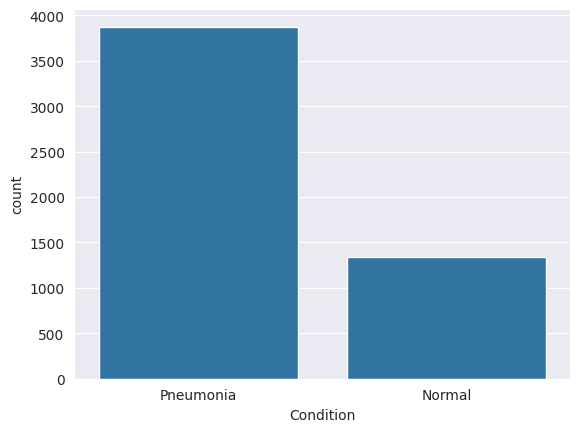

In [8]:
l = []
for i in train:
    if (i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')

#Converding the list into a dataframe so that countplot can accept it.
df = pd.DataFrame({"Condition": l})


sns.countplot(x="Condition", data=df)

### Previewing the images of both the classes.

Text(0.5, 1.0, 'NORMAL')

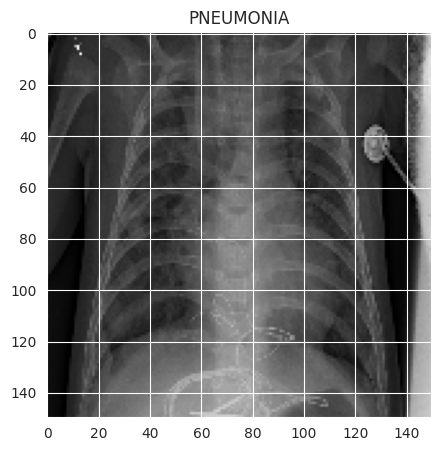

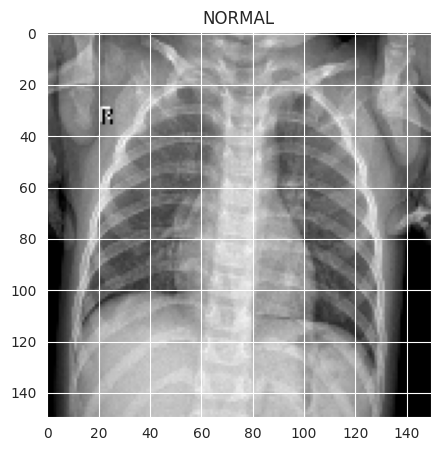

In [9]:
plt.figure(figsize= (5,5))
plt.imshow(train[0][0], cmap="gray")
plt.title(labels[train[0][1]])


plt.figure(figsize= (5,5))
plt.imshow(train[-1][0], cmap="gray")
plt.title(labels[train[-1][1]])

### We perform a grayscale normalization to reduce the effect of illumination's differences. Moreover, the CNN converges faster on [0..1] data than on [0...255]

In [2]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Make them into arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

NameError: name 'train' is not defined

In [11]:
# try to resize data to mauybe get better output.
x_train = x_train.reshape(-1, img_size, img_size, 1)


x_test = x_test.reshape(-1, img_size, img_size, 1)


x_val = x_val.reshape(-1, img_size, img_size, 1)


### Data Augmentation

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [13]:
datagen.fit(x_train)

### Training the Model

In [14]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

# DIT IS AL GERUND, DOE HET NIET OPNIEUW TENZIJ JE KOSTBARE TIJD WILT VERSPILLN

In [16]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12, validation_data= datagen.flow(x_val, y_val), callbacks =[learning_rate_reduction])

Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.8004 - loss: 1.5300 - val_accuracy: 0.5000 - val_loss: 8.8254 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.8946 - loss: 0.3084 - val_accuracy: 0.5000 - val_loss: 37.4807 - learning_rate: 0.0010
Epoch 3/12
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9191 - loss: 0.2124
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9191 - loss: 0.2125 - val_accuracy: 0.5000 - val_loss: 17.2420 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9395 - loss: 0.1713 - val_accuracy: 0.5000 - val_loss: 6.1499 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9475 - loss: 0.1452 - val_accuracy: 0.5625 - val_loss: 1.5387 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9472 - loss: 0.1

In [17]:
print("Loss of the model is - " , model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8420 - loss: 0.2980
Loss of the model is -  0.29618456959724426
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8420 - loss: 0.2980
Accuracy of the model is -  86.69871687889099 %


In [21]:
model.save("Base86.keras")

### Analysis after model training

NameError: name 'history' is not defined

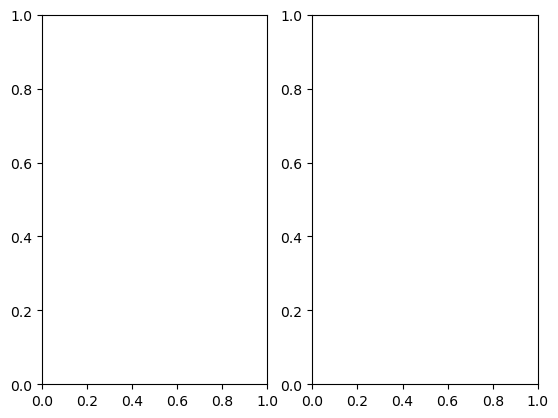

In [2]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [29]:
# predictions = model.predict_classes(x_test)
predictions = (model.predict(x_test) > 0.5).astype("int32").flatten()
predictions = predictions.reshape(1,-1)[0]
predictions[:46]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0], dtype=int32)

In [30]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.85      0.89       390
   Normal (Class 1)       0.78      0.90      0.84       234

           accuracy                           0.87       624
          macro avg       0.86      0.87      0.86       624
       weighted avg       0.88      0.87      0.87       624



In [41]:
cm = confusion_matrix(y_test,predictions)
cm

array([[330,  60],
       [ 23, 211]])

### Deze stuk hoeft aleen als er sns.heatmap gebruiken, maar dat zorgde dat niet alle cijfers zichtbaar waren dus heb CunfusionMatrixDisplay gebruikt.

<Figure size 1000x1000 with 0 Axes>

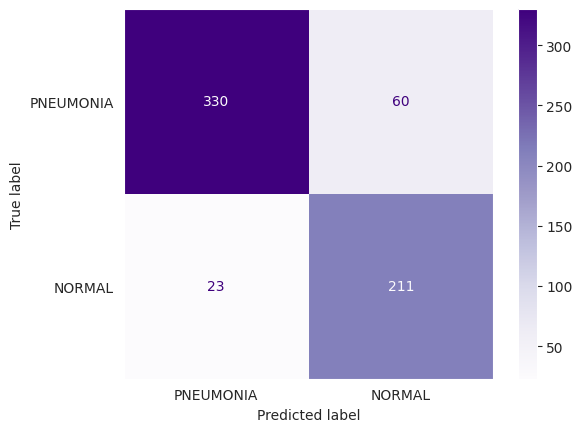

In [36]:
plt.figure(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Purples', colorbar=True)
plt.grid(False)


In [37]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

### Some correctly predicted classes

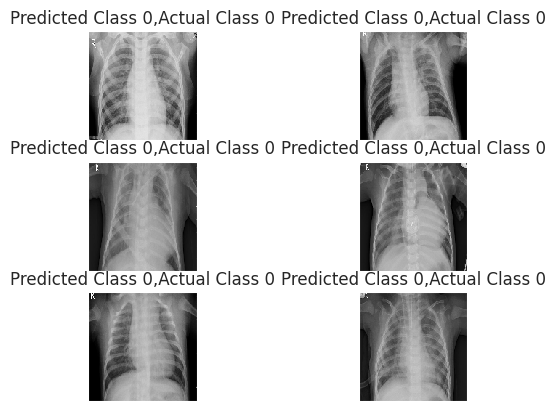

In [38]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    # plt.tight_layout()
    i += 1

### Some incorrectly predicted classes

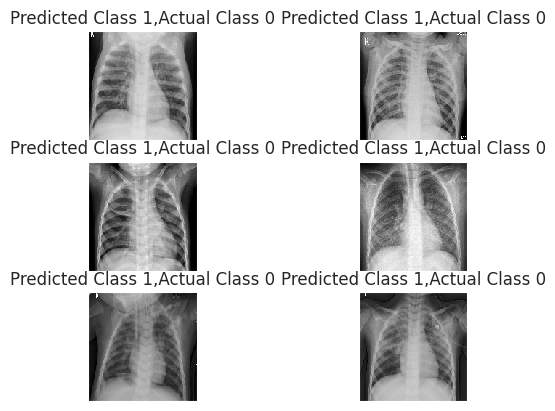

In [39]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    # plt.tight_layout()
    i += 1

##Going to Part 2 of the assignment trying to Hyper-Parameter Optimization / Bayesian Optimization


#Code of Bayesian Optimization
####(Is comentend no longer needed)

In [ ]:
# def objective(trial):
#     # --- Hyperparameter suggestions ---
#     filters1 = trial.suggest_categorical('filters1', [32, 64])
#     dropout1 = trial.suggest_categorical('dropout1', [0.1, 0.15])
#     dropout2 = trial.suggest_categorical('dropout2', [0.15, 0.25])
#     kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
#     learning_factor = trial.suggest_categorical('learning_factor', [0.1, 0.25, 0.5, 0.75, 0.9])

#     if filters1 == 32:
#         dense_units = trial.suggest_int('dense_units', 64, 128)
#     else:
#         dense_units = trial.suggest_int('dense_units', 128, 256)

#     # --- Build the model ---
#     model = Sequential()
#     model.add(Conv2D(filters1, (kernel_size, kernel_size), strides = 1,activation='relu', padding='same', input_shape=(150, 150, 1)))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides = 2, padding='same'))

#     model.add(Conv2D(filters1, (kernel_size, kernel_size), strides = 1, activation='relu', padding='same'))
#     model.add(Dropout(dropout1))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides =2, padding='same'))

#     model.add(Conv2D(filters1 * 2, (kernel_size, kernel_size), strides = 1, activation='relu', padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides = 2, padding='same'))

#     model.add(Conv2D(filters1 * 2, (kernel_size, kernel_size), strides = 1, activation='relu', padding='same'))
#     model.add(Dropout(dropout1))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides =2, padding='same'))

#     model.add(Conv2D(filters1 * 4, (kernel_size, kernel_size), strides =1, activation='relu', padding='same'))
#     model.add(Dropout(dropout2))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides = 2, padding='same'))

#     model.add(Flatten())
#     model.add(Dense(dense_units, activation='relu'))
#     model.add(Dropout(dropout2))
#     model.add(Dense(1, activation='sigmoid'))

#     # --- Compile ---
#     model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

#     # --- Callbacks ---
#     callbacks = [
#         EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
#         ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=learning_factor, min_lr=1e-6)
#     ]

#     # --- Train ---
#     history = model.fit(
#         datagen.flow(x_train, y_train, batch_size=32),
#         epochs=12,
#         validation_data=datagen.flow(x_val, y_val),
#         callbacks=callbacks
#     )

#     # Return validation accuracy of last epoch
#     return history.history['val_accuracy'][-1]


In [ ]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=20)

In [ ]:
model10 = Sequential()
model10.add(Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(Dropout(0.1))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(64 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(64 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(Dropout(0.1))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(128 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(Dropout(0.15))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Flatten())
model10.add(Dense(units = 70 , activation = 'relu'))
model10.add(Dropout(0.15))
model10.add(Dense(units = 1 , activation = 'sigmoid'))
model10.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model10.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 150, 150, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 75, 75, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 38, 38, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 38, 38, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 19, 19, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 19, 19, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 10, 10, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3200)                │              

 Total params: 610,541 (2.33 MB)

 Trainable params: 609,901 (2.33 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
learning_rate_reduction10 = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model10.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=40, validation_data= datagen.flow(x_val, y_val), callbacks =[learning_rate_reduction10])

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.7891 - loss: 0.7154 - val_accuracy: 0.5000 - val_loss: 17.8312 - learning_rate: 0.0010
Epoch 2/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.8889 - loss: 0.2713 - val_accuracy: 0.5000 - val_loss: 21.5829 - learning_rate: 0.0010
Epoch 3/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9135 - loss: 0.2355
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9136 - loss: 0.2354 - val_accuracy: 0.5000 - val_loss: 26.6777 - learning_rate: 0.0010
Epoch 4/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9419 - loss: 0.1566 - val_accuracy: 0.5000 - val_loss: 18.1245 - learning_rate: 3.0000e-04
Epoch 5/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9510 - loss: 0.1343 - val_accuracy: 0.6875 - val_loss: 0.7121 - learning_rate: 3.0000e-04
Epoch 6/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9547 - loss: 0

In [ ]:
print("Loss of the model is - " , model10.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - " , model10.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9422 - loss: 0.1536
Loss of the model is -  0.21630392968654633
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9422 - loss: 0.1536
Accuracy of the model is -  91.82692170143127 %


In [ ]:
predictions = (model10.predict(x_test) > 0.5).astype("int32").flatten()
predictions = predictions.reshape(1,-1)[0]
predictions[:46]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.91      0.96      0.94       390
   Normal (Class 1)       0.93      0.84      0.89       234

           accuracy                           0.92       624
          macro avg       0.92      0.90      0.91       624
       weighted avg       0.92      0.92      0.92       624



In [ ]:
cm = confusion_matrix(y_test,predictions)

<Figure size 1000x1000 with 0 Axes>

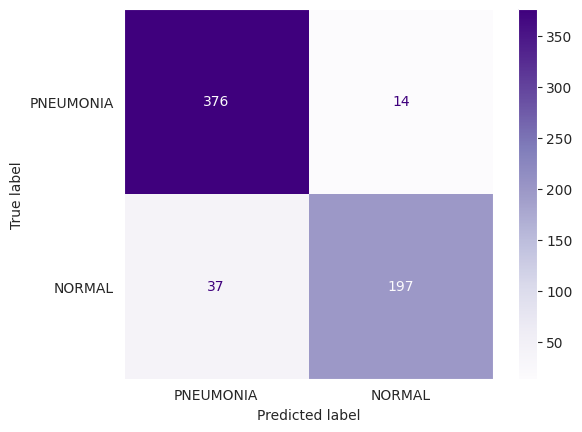

In [ ]:
plt.figure(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Purples', colorbar=True)
plt.grid(False)


In [1]:
model10.save("Ours.keras")

NameError: name 'model10' is not defined

In [43]:
ours = keras.saving.load_model("92_Percent.keras")

In [45]:
predictions = (ours.predict(x_train) > 0.5).astype("int32").flatten()
predictions = predictions.reshape(1,-1)[0]
predictions[:46]

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

In [46]:
print(classification_report(y_train, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.99      0.92      0.96      3875
   Normal (Class 1)       0.81      0.99      0.89      1341

           accuracy                           0.94      5216
          macro avg       0.90      0.95      0.92      5216
       weighted avg       0.95      0.94      0.94      5216



In [47]:
cm = confusion_matrix(y_train,predictions)

<Figure size 1000x1000 with 0 Axes>

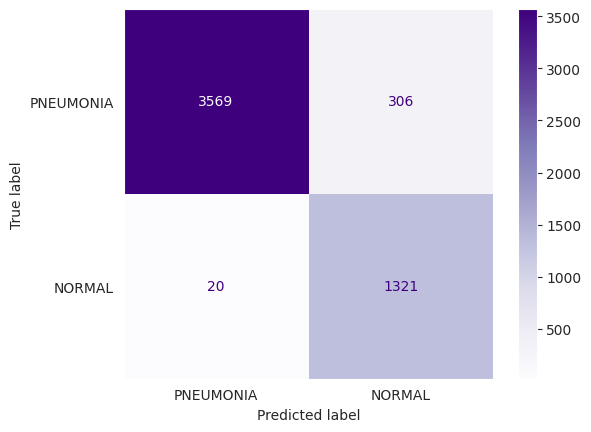

In [48]:
plt.figure(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Purples', colorbar=True)
plt.grid(False)